#  Support Vector Machine on DonorsChoose

DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website. Next year, DonorsChoose.org expects to receive close to 500,000 project proposals. As a result, there are three main problems they need to solve: How to scale current manual processes and resources to screen 500,000 projects so that they can be posted as quickly and as efficiently as possible How to increase the consistency of project vetting across different volunteers to improve the experience for teachers How to focus volunteer time on the applications that need the most assistance

The goal of the competition is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval.

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
import chart_studio.plotly as py
from scipy.sparse import hstack
import chart_studio.plotly as py


from collections import Counter

## 1. LOAD AND PROCESS DATA

### 1.1 Reading Data

In [2]:
data=pd.read_csv("train_data.csv")
resource_data=pd.read_csv("resources.csv")
data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories',
       'project_title', 'project_essay_1', 'project_essay_2',
       'project_essay_3', 'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved'],
      dtype='object')

In [3]:
price_data=resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()

In [4]:
project_data=pd.merge(data, price_data, on='id', how='left')

In [5]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories',
       'project_title', 'project_essay_1', 'project_essay_2',
       'project_essay_3', 'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'price', 'quantity'],
      dtype='object')

### 1.2 process Project Essay

In [6]:
project_data.head(3)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,price,quantity
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Literacy & Language,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,154.60,23
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,"History & Civics, Health & Sports","Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,299.00,1
2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,Ms.,AZ,2016-08-31 12:03:56,Grades 6-8,Health & Sports,"Health & Wellness, Team Sports",Soccer Equipment for AWESOME Middle School Stu...,"\r\n\""True champions aren't always the ones th...",The students on the campus come to school know...,NaN,NaN,"My students need shine guards, athletic socks,...",1,0,516.85,22


In [7]:
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                project_data["project_essay_2"].map(str) + \
                project_data["project_essay_3"].map(str) + \
                project_data["project_essay_4"].map(str)

In [8]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [9]:
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [10]:
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_essays.append(sent.lower().strip())
project_data['cleaned_essay']=preprocessed_essays

100%|██████████| 109248/109248 [00:59<00:00, 1843.86it/s]


### 1.2 process Project Title

In [11]:
# https://stackoverflow.com/a/47091490/4084039
from tqdm import tqdm
preprocessed_title = []
# tqdm is for printing the status bar
for sentance in tqdm(data['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_title.append(sent.lower().strip())
project_data['cleaned_project_title']=preprocessed_title

100%|██████████| 109248/109248 [00:02<00:00, 37710.26it/s]


### 1.3 teacher_prefix

In [12]:
temp1=data.teacher_prefix.apply(lambda x: str(x).replace('.', ''))
project_data['teacher_prefix']=temp1
project_data['teacher_prefix'].value_counts()


Mrs        57269
Ms         38955
Mr         10648
Teacher     2360
Dr            13
nan            3
Name: teacher_prefix, dtype: int64

### 1.4 project grade

In [13]:
project_data.project_grade_category.value_counts()

Grades PreK-2    44225
Grades 3-5       37137
Grades 6-8       16923
Grades 9-12      10963
Name: project_grade_category, dtype: int64

In [14]:
grade_list=[]
for i in project_data['project_grade_category'].values:
    i=i.replace(' ','_')
    i=i.replace('-','_')
    grade_list.append(i.strip()) 
    
    
project_data['project_grade_category']=grade_list  
       
   

In [15]:
project_data['project_grade_category'].value_counts()

Grades_PreK_2    44225
Grades_3_5       37137
Grades_6_8       16923
Grades_9_12      10963
Name: project_grade_category, dtype: int64

### 1.5 project_subject_categories

In [16]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())
    
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))

### 1.6 project_subject_subcategories

In [17]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

### 1.7 counting words in title

In [18]:
#https://stackoverflow.com/questions/49984905/count-number-of-words-per-row
project_data['totalwords_title'] = project_data['cleaned_project_title'].str.split().str.len()

### 1.8 number of words in the essay

In [19]:
project_data['totalwords_essay'] = project_data['cleaned_essay'].str.split().str.len()

### 1.9 sentiment score's of each of the essay

In [20]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()
neg=[]
compound=[]
pos=[]
neu=[]
for sent in (project_data['cleaned_essay'].values):
    score = analyser.polarity_scores(sent)
    neg.append(score.get('neg'))
    neu.append(score.get('neu'))
    pos.append(score.get('pos'))
    compound.append(score.get('compound'))
project_data['neg']=neg
project_data['neu']=neu
project_data['pos']=pos
project_data['compound']=compound

### 1.10 droping unnecesarry columns

In [21]:
project_data.drop(['project_title'], axis=1, inplace=True)
project_data.drop(['project_essay_1'], axis=1, inplace=True)
project_data.drop(['project_essay_2'], axis=1, inplace=True)
project_data.drop(['project_essay_3'], axis=1, inplace=True)
project_data.drop(['project_essay_4'], axis=1, inplace=True)

In [22]:
project_data.head(3)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,...,cleaned_essay,cleaned_project_title,clean_categories,clean_subcategories,totalwords_title,totalwords_essay,neg,neu,pos,compound
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs,IN,2016-12-05 13:43:57,Grades_PreK_2,My students need opportunities to practice beg...,0,0,...,my students english learners working english s...,educational support english learners home,Literacy_Language,ESL Literacy,5,161,0.012,0.845,0.143,0.9694
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr,FL,2016-10-25 09:22:10,Grades_6_8,My students need a projector to help with view...,7,1,...,our students arrive school eager learn they po...,wanted projector hungry learners,History_Civics Health_Sports,Civics_Government TeamSports,4,109,0.048,0.668,0.284,0.9860
2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,Ms,AZ,2016-08-31 12:03:56,Grades_6_8,"My students need shine guards, athletic socks,...",1,0,...,true champions not always ones win guts by mia...,soccer equipment awesome middle school students,Health_Sports,Health_Wellness TeamSports,6,202,0.076,0.656,0.268,0.9939


### 1.11 Making dependant(label) and independant variables

In [23]:
y = project_data['project_is_approved'].values
project_data.drop(['project_is_approved'], axis=1, inplace=True)
project_data.head(1)
x=project_data
x.head(3)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_resource_summary,teacher_number_of_previously_posted_projects,price,...,cleaned_essay,cleaned_project_title,clean_categories,clean_subcategories,totalwords_title,totalwords_essay,neg,neu,pos,compound
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs,IN,2016-12-05 13:43:57,Grades_PreK_2,My students need opportunities to practice beg...,0,154.60,...,my students english learners working english s...,educational support english learners home,Literacy_Language,ESL Literacy,5,161,0.012,0.845,0.143,0.9694
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr,FL,2016-10-25 09:22:10,Grades_6_8,My students need a projector to help with view...,7,299.00,...,our students arrive school eager learn they po...,wanted projector hungry learners,History_Civics Health_Sports,Civics_Government TeamSports,4,109,0.048,0.668,0.284,0.9860
2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,Ms,AZ,2016-08-31 12:03:56,Grades_6_8,"My students need shine guards, athletic socks,...",1,516.85,...,true champions not always ones win guts by mia...,soccer equipment awesome middle school students,Health_Sports,Health_Wellness TeamSports,6,202,0.076,0.656,0.268,0.9939


### 1.12 Traing and Test split

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.33, stratify=y,random_state=42)
X_train, X_cv, Y_train, Y_cv = train_test_split(X_train, Y_train, test_size=0.33, stratify=Y_train,random_state=42)


## 2.Text Vectorization and encoding catagories,normalization numerical features

### 2.1 converting the title to vectors using TFIDF

In [25]:
vectorizer = TfidfVectorizer(min_df=10)
vectorizer.fit(X_train['cleaned_project_title'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_title_tfidf = vectorizer.transform(X_train['cleaned_project_title'].values)
X_cv_title_tfidf = vectorizer.transform(X_cv['cleaned_project_title'].values)
X_test_title_tfidf = vectorizer.transform(X_test['cleaned_project_title'].values)

print("After vectorizations")
print(X_train_title_tfidf.shape, Y_train.shape)
print(X_cv_title_tfidf.shape, Y_cv.shape)
print(X_test_title_tfidf.shape, Y_test.shape)
print("="*100)

After vectorizations
(49041, 2080) (49041,)
(24155, 2080) (24155,)
(36052, 2080) (36052,)


### 2.2 converting the title to vectors using TFIDF

In [26]:
vectorizer = TfidfVectorizer(min_df=10)
vectorizer.fit(X_train['cleaned_essay'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_tfidf = vectorizer.transform(X_train['cleaned_essay'].values)
X_cv_essay_tfidf = vectorizer.transform(X_cv['cleaned_essay'].values)
X_test_essay_tfidf = vectorizer.transform(X_test['cleaned_essay'].values)

print("After vectorizations")
print(X_train_title_tfidf.shape, Y_train.shape)
print(X_cv_title_tfidf.shape, Y_cv.shape)
print(X_test_title_tfidf.shape, Y_test.shape)
print("="*100)

After vectorizations
(49041, 2080) (49041,)
(24155, 2080) (24155,)
(36052, 2080) (36052,)


### 2.3 load glove model

In [27]:
# Reading glove vectors in python: https://stackoverflow.com/a/38230349/4084039
def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    f = open(gloveFile,'r', encoding="utf8")
    model = {}
    for line in tqdm(f):
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print ("Done.",len(model)," words loaded!")
    return model
model = loadGloveModel('glove.42B.300d.txt')

# ============================
'''Output:
    
Loading Glove Model
1917495it [06:32, 4879.69it/s]
Done. 1917495  words loaded!
'''
# ============================

734it [00:00, 7338.38it/s]

Loading Glove Model


1917495it [03:54, 8171.95it/s]

Done. 1917495  words loaded!


'Output:\n    \nLoading Glove Model\n1917495it [06:32, 4879.69it/s]\nDone. 1917495  words loaded!\n'

In [28]:

words = []
for i in X_train['cleaned_essay'].values:
    words.extend(i.split(' '))

for i in X_train['cleaned_project_title'].values:
    words.extend(i.split(' '))
print("all the words in the coupus", len(words))
words = set(words)
print("the unique words in the coupus", len(words))

inter_words = set(model.keys()).intersection(words)
print("The number of words that are present in both glove vectors and our coupus", \
      len(inter_words),"(",np.round(len(inter_words)/len(words)*100,3),"%)")

words_courpus = {}
words_glove = set(model.keys())
for i in words:
    if i in words_glove:
        words_courpus[i] = model[i]
print("word 2 vec length", len(words_courpus))


# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

import pickle
with open('glove_vectors', 'wb') as f:
    pickle.dump(words_courpus, f)

all the words in the coupus 7628532
the unique words in the coupus 42937
The number of words that are present in both glove vectors and our coupus 39195 ( 91.285 %)
word 2 vec length 39195


In [29]:

# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

### 2.4 TFIDF weighted W2V on essay

In [30]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['cleaned_essay'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [31]:

Text_tfidf_w2v_train_essay= []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['cleaned_essay'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    Text_tfidf_w2v_train_essay.append(vector)

print(len(Text_tfidf_w2v_train_essay))
print(len(Text_tfidf_w2v_train_essay[0]))

100%|██████████| 49041/49041 [02:17<00:00, 357.78it/s]

49041
300


In [32]:
Text_tfidf_w2v_cv_essay= []; 
for sentence in tqdm(X_cv['cleaned_essay'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    Text_tfidf_w2v_cv_essay.append(vector)

print(len(Text_tfidf_w2v_cv_essay))
print(len(Text_tfidf_w2v_cv_essay[0]))

100%|██████████| 24155/24155 [01:03<00:00, 380.00it/s]

24155
300


In [33]:
Text_tfidf_w2v_test_essay= []; 
for sentence in tqdm(X_test['cleaned_essay'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    Text_tfidf_w2v_test_essay.append(vector)

print(len(Text_tfidf_w2v_test_essay))
print(len(Text_tfidf_w2v_test_essay[0]))

100%|██████████| 36052/36052 [01:34<00:00, 382.88it/s]

36052
300


### 2.5 TFIDF weighted W2V on title

In [34]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['cleaned_project_title'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [35]:

Text_tfidf_w2v_train_title= []; 
for sentence in tqdm(X_train['cleaned_project_title'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    Text_tfidf_w2v_train_title.append(vector)

print(len(Text_tfidf_w2v_train_title))
print(len(Text_tfidf_w2v_train_title[0]))

100%|██████████| 49041/49041 [00:01<00:00, 28175.26it/s]

49041
300


In [36]:
Text_tfidf_w2v_cv_title= []; 
for sentence in tqdm(X_cv['cleaned_project_title'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    Text_tfidf_w2v_cv_title.append(vector)

print(len(Text_tfidf_w2v_cv_title))
print(len(Text_tfidf_w2v_cv_title[0]))

100%|██████████| 24155/24155 [00:00<00:00, 28579.10it/s]

24155
300


In [37]:
Text_tfidf_w2v_test_title= []; 
for sentence in tqdm(X_test['cleaned_project_title'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    Text_tfidf_w2v_test_title.append(vector)

print(len(Text_tfidf_w2v_test_title))
print(len(Text_tfidf_w2v_test_title[0]))

100%|██████████| 36052/36052 [00:01<00:00, 28744.85it/s]

36052
300


### 2.6 one hot encoding the catogorical features: teacher_prefix

In [38]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['teacher_prefix'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_teacher_ohe = vectorizer.transform(X_train['teacher_prefix'].values)
X_cv_teacher_ohe = vectorizer.transform(X_cv['teacher_prefix'].values)
X_test_teacher_ohe = vectorizer.transform(X_test['teacher_prefix'].values)

print("After vectorizations")
print(X_train_teacher_ohe.shape, Y_train.shape)
print(X_cv_teacher_ohe.shape, Y_cv.shape)
print(X_test_teacher_ohe.shape, Y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(49041, 6) (49041,)
(24155, 6) (24155,)
(36052, 6) (36052,)
['dr', 'mr', 'mrs', 'ms', 'nan', 'teacher']


### 2.7 one hot encoding the catogorical features: project Grade

In [39]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['project_grade_category'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_grade_ohe = vectorizer.transform(X_train['project_grade_category'].values)
X_cv_grade_ohe = vectorizer.transform(X_cv['project_grade_category'].values)
X_test_grade_ohe = vectorizer.transform(X_test['project_grade_category'].values)

print("After vectorizations")
print(X_train_grade_ohe.shape, Y_train.shape)
print(X_cv_grade_ohe.shape, Y_cv.shape)
print(X_test_grade_ohe.shape, Y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(49041, 4) (49041,)
(24155, 4) (24155,)
(36052, 4) (36052,)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']


### 2.8 one hot encoding the catogorical features: state

In [40]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['school_state'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_state_ohe = vectorizer.transform(X_train['school_state'].values)
X_cv_state_ohe = vectorizer.transform(X_cv['school_state'].values)
X_test_state_ohe = vectorizer.transform(X_test['school_state'].values)

print("After vectorizations")
print(X_train_state_ohe.shape, Y_train.shape)
print(X_cv_state_ohe.shape, Y_cv.shape)
print(X_test_state_ohe.shape, Y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(49041, 51) (49041,)
(24155, 51) (24155,)
(36052, 51) (36052,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


### 2.9 one hot encoding the catogorical features:clean_categories

In [41]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_categories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_clean_categories_ohe = vectorizer.transform(X_train['clean_categories'].values)
X_cv_clean_categories_ohe = vectorizer.transform(X_cv['clean_categories'].values)
X_test_clean_categories_ohe = vectorizer.transform(X_test['clean_categories'].values)

print("After vectorizations")
print(X_train_clean_categories_ohe.shape, Y_train.shape)
print(X_cv_clean_categories_ohe.shape, Y_cv.shape)
print(X_test_clean_categories_ohe.shape, Y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(49041, 9) (49041,)
(24155, 9) (24155,)
(36052, 9) (36052,)
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']


### 2.10 one hot encoding the catogorical features:clean_subcategories

In [42]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_subcategories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_clean_subcategories_ohe = vectorizer.transform(X_train['clean_subcategories'].values)
X_cv_clean_subcategories_ohe = vectorizer.transform(X_cv['clean_subcategories'].values)
X_test_clean_subcategories_ohe = vectorizer.transform(X_test['clean_subcategories'].values)

print("After vectorizations")
print(X_train_clean_subcategories_ohe.shape, Y_train.shape)
print(X_cv_clean_subcategories_ohe.shape, Y_cv.shape)
print(X_test_clean_subcategories_ohe.shape, Y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(49041, 30) (49041,)
(24155, 30) (24155,)
(36052, 30) (36052,)
['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']


### 2.11 Normalizing the numerical features: Price

In [43]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train['price'].values.reshape(-1,1))

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(-1,1))
X_cv_price_norm = normalizer.transform(X_cv['price'].values.reshape(-1,1))
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_price_norm.shape, Y_train.shape)
print(X_cv_price_norm.shape, Y_cv.shape)
print(X_test_price_norm.shape, Y_test.shape)
print("="*100)

After vectorizations
(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)


### 2.12 Normalizing the numerical features:teacher_number_of_previously_posted_projects

In [44]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

X_train_TPPP_norm = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_cv_TPPP_norm = normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_TPPP_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_TPPP_norm.shape, Y_train.shape)
print(X_cv_TPPP_norm.shape, Y_cv.shape)
print(X_test_TPPP_norm.shape, Y_test.shape)
print("="*100)

After vectorizations
(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)


### 2.13 Normalizing the numerical features: quantity

In [45]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train['quantity'].values.reshape(-1,1))

X_train_quantity_norm = normalizer.transform(X_train['quantity'].values.reshape(-1,1))
X_cv_quantity_norm = normalizer.transform(X_cv['quantity'].values.reshape(-1,1))
X_test_quantity_norm = normalizer.transform(X_test['quantity'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_quantity_norm.shape, Y_train.shape)
print(X_cv_quantity_norm.shape, Y_cv.shape)
print(X_test_quantity_norm.shape, Y_test.shape)
print("="*100)

After vectorizations
(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)


### 2.14 Normalizing the numerical features: totalwords_title

In [46]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train['totalwords_title'].values.reshape(-1,1))

X_train_totalwords_title_norm = normalizer.transform(X_train['totalwords_title'].values.reshape(-1,1))
X_cv_totalwords_title_norm = normalizer.transform(X_cv['totalwords_title'].values.reshape(-1,1))
X_test_totalwords_title_norm = normalizer.transform(X_test['totalwords_title'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_totalwords_title_norm.shape, Y_train.shape)
print(X_cv_totalwords_title_norm.shape, Y_cv.shape)
print(X_test_totalwords_title_norm.shape, Y_test.shape)
print("="*100)

After vectorizations
(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)


### 2.15 adding sentimental score: sentimental score of essay

In [47]:

X_train_essay_sentiment_neg = X_train['neg']
X_train_essay_sentiment_neu = X_train['neu']
X_train_essay_sentiment_pos = X_train['pos']
X_train_essay_sentiment_compound = X_train['compound']

X_cv_essay_sentiment_neg = X_cv['neg']
X_cv_essay_sentiment_neu = X_cv['neu']
X_cv_essay_sentiment_pos = X_cv['pos']
X_cv_essay_sentiment_compound = X_cv['compound']

X_test_essay_sentiment_neg = X_test['neg']
X_test_essay_sentiment_neu = X_test['neu']
X_test_essay_sentiment_pos = X_test['pos']
X_test_essay_sentiment_compound = X_test['compound']


print("After vectorizations")
print(X_train_essay_sentiment_neg.shape, Y_train.shape)
print(X_cv_essay_sentiment_neg.shape, Y_cv.shape)
print(X_test_essay_sentiment_neg.shape, Y_test.shape)


print("="*100)

After vectorizations
(49041,) (49041,)
(24155,) (24155,)
(36052,) (36052,)


In [48]:

X_train_essay_sentiment_neg = X_train['neg'].values.reshape(-1,1)
X_train_essay_sentiment_neu = X_train['neu'].values.reshape(-1,1)
X_train_essay_sentiment_pos = X_train['pos'].values.reshape(-1,1)
X_train_essay_sentiment_compound = X_train['compound'].values.reshape(-1,1)

X_cv_essay_sentiment_neg = X_cv['neg'].values.reshape(-1,1)
X_cv_essay_sentiment_neu = X_cv['neu'].values.reshape(-1,1)
X_cv_essay_sentiment_pos = X_cv['pos'].values.reshape(-1,1)
X_cv_essay_sentiment_compound = X_cv['compound'].values.reshape(-1,1)

X_test_essay_sentiment_neg = X_test['neg'].values.reshape(-1,1)
X_test_essay_sentiment_neu = X_test['neu'].values.reshape(-1,1)
X_test_essay_sentiment_pos = X_test['pos'].values.reshape(-1,1)
X_test_essay_sentiment_compound = X_test['compound'].values.reshape(-1,1)


print("After vectorizations")
print(X_train_essay_sentiment_neg.shape, Y_train.shape)
print(X_cv_essay_sentiment_neg.shape, Y_cv.shape)
print(X_test_essay_sentiment_neg.shape, Y_test.shape)


print("="*100)

After vectorizations
(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)


### 2.16 Normalizing the numerical features: totalwords_essay

In [49]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train['totalwords_essay'].values.reshape(-1,1))

X_train_totalwords_essay_norm = normalizer.transform(X_train['totalwords_essay'].values.reshape(-1,1))
X_cv_totalwords_essay_norm = normalizer.transform(X_cv['totalwords_essay'].values.reshape(-1,1))
X_test_totalwords_essay_norm = normalizer.transform(X_test['totalwords_essay'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_totalwords_essay_norm.shape, Y_train.shape)
print(X_cv_totalwords_essay_norm.shape, Y_cv.shape)
print(X_test_totalwords_essay_norm.shape, Y_test.shape)
print("="*100)

After vectorizations
(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)


### 2.17 counting false positive

In [50]:

FP_essay_test_tfidf=[]
FP_price_test_tfidf=[]
FP_previous_posted_test_tfidf=[]

FP_essay_test_tfidfw2v=[]
FP_price_test_tfidfw2v=[]
FP_previous_posted_test_tfidfw2v=[]

FP_essay_test_fetureimp=[]
FP_price_test_fetureimp=[]
FP_previous_posted_test_fetureimp=[]


def retrievingFalsePositives(Number):
     
    if(Number==1):  
        FP_test_tfidf=[]
        for i in range(len(Y_test)):
            if(Y_test[i]==0 and predictions_test_tfidf[i]==1 ):
                FP_test_tfidf.append(i)

        for i in FP_test_tfidf:
            FP_essay_test_tfidf.append(X_test['cleaned_essay'].values[i])
            FP_price_test_tfidf.append(X_test['price'].values[i])
            FP_previous_posted_test_tfidf.append(X_test['teacher_number_of_previously_posted_projects'].values[i])

    if(Number==2):  
        FP_test_tfidfw2v=[]
        for i in range(len(Y_test)):
            if(Y_test[i]==0 and predictions_test_tfidfw2v[i]==1 ):
                FP_test_tfidfw2v.append(i)
        for i in FP_test_tfidfw2v:
            FP_essay_test_tfidfw2v.append(X_test['cleaned_essay'].values[i])
            FP_price_test_tfidfw2v.append(X_test['price'].values[i])
            FP_previous_posted_test_tfidfw2v.append(X_test['teacher_number_of_previously_posted_projects'].values[i])
            
    if(Number==3):  
        FP_test_fetureimp=[]
        for i in range(len(Y_test)):
            if(Y_test[i]==0 and predictions_train_Feimp[i]==1 ):
                FP_test_fetureimp.append(i)
        for i in FP_test_fetureimp:
            FP_essay_test_fetureimp.append(X_test['cleaned_essay'].values[i])
            FP_price_test_fetureimp.append(X_test['price'].values[i])
            FP_previous_posted_test_fetureimp.append(X_test['teacher_number_of_previously_posted_projects'].values[i])

### 2.18 Functions of worldcloud,pdf,boxplot

In [51]:
# importing all necessary modules
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from PIL import Image # for masking i.e print word in the pattern we want
import pandas as pd

# Read 'Youtube04-Eminem.csv' files
# using encoding = "latin-1" to get vertical words arrangement along with horizontal once
# dataFrame = pd.read_csv(r"Youtube04-Eminem.csv", encoding = "latin-1")
# dataFrame.head()
def showtWordCloud(FP_data):
    comment_words = ''
    stopwords = set(STOPWORDS) 

    # for val in dataFrame.CONTENT: 
    for val in FP_data: 

        # typecaste each val to string 
        val = str(val) 

        # split the value 
        tokens = val.split() 

        # Converts each token into lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 

        for words in tokens: 
            comment_words = comment_words + words + ' '


    wordcloud = WordCloud(width = 500, height = 500, 
                    background_color ='white', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(comment_words) 

    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

In [52]:
def drawBoxPlot(FP_data):
    plt.boxplot(FP_data)
    plt.title('Box Plot for PRICE in False Positives')
    plt.ylabel('Price')
    plt.grid()
    plt.show()

In [53]:
def drawPDF(FP_data):
    plt.figure(figsize=(10,3))
    sns.distplot(FP_data)
    plt.title('PDF for Teacher number who previously posted projects in False Positives')
    plt.xlabel('Teacher number who previously posted projects')
    plt.legend()
    plt.show()

## 3. Decision Tree on TFIDF

In [54]:
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(tpr*(1-fpr))]

    
    #(tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    #print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)    
    return predictions

In [55]:
def myplot_matrix1(data):
    plt.clf()
    plt.imshow(data, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ['Negative','Positive']
    plt.title('Approved not approved matrix')
    tick_marks = np.arange(len(classNames))
    
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FN'], ['FP', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(data[i][j]))
    plt.show()

### 3.1 TFIDF:Concatinating all the features

In [56]:

X_tr_tfidf=hstack((X_train_essay_tfidf,X_train_title_tfidf,X_train_state_ohe,X_train_clean_categories_ohe,X_train_clean_subcategories_ohe,X_train_grade_ohe,X_train_teacher_ohe,X_train_quantity_norm,X_train_TPPP_norm,X_train_price_norm,X_train_totalwords_essay_norm,X_train_essay_sentiment_neg,X_train_essay_sentiment_neu,X_train_essay_sentiment_pos,X_train_essay_sentiment_compound)).tocsr()
X_cr_tfidf=hstack((X_cv_essay_tfidf,X_cv_title_tfidf,X_cv_state_ohe,X_cv_clean_categories_ohe,X_cv_clean_subcategories_ohe,X_cv_grade_ohe,X_cv_teacher_ohe,X_cv_quantity_norm,X_cv_TPPP_norm,X_cv_price_norm,X_cv_totalwords_essay_norm,X_cv_essay_sentiment_neg,X_cv_essay_sentiment_neu,X_cv_essay_sentiment_pos,X_cv_essay_sentiment_compound)).tocsr()
X_te_tfidf=hstack((X_test_essay_tfidf,X_test_title_tfidf,X_test_state_ohe,X_test_clean_categories_ohe,X_test_clean_subcategories_ohe,X_test_grade_ohe,X_test_teacher_ohe,X_test_quantity_norm,X_test_TPPP_norm,X_test_price_norm,X_test_totalwords_essay_norm,X_test_essay_sentiment_neg,X_test_essay_sentiment_neu,X_test_essay_sentiment_pos,X_test_essay_sentiment_compound)).tocsr()

print("Final Data matrix")
print(X_tr_tfidf.shape, Y_train.shape)
print(X_cr_tfidf.shape, Y_cv.shape)
print(X_te_tfidf.shape, Y_test.shape)
print("="*100)

Final Data matrix
(49041, 14320) (49041,)
(24155, 14320) (24155,)
(36052, 14320) (36052,)


### 3.2 Hyper parameter Tuning:simple for loop for Train and cross validation

In [57]:
## SVM
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

Dt_tfidf = DecisionTreeClassifier(class_weight='balanced')
parameters = {'max_depth':[1, 5, 10, 50],'min_samples_split':[5, 10, 100, 500]}
model = GridSearchCV(Dt_tfidf, parameters, cv= 3, scoring='roc_auc',verbose=1,return_train_score=True,n_jobs=-1)

model.fit(X_tr_tfidf,Y_train)
train_auc= model.cv_results_['mean_train_score']
train_auc_std= model.cv_results_['std_train_score']
cv_auc = model.cv_results_['mean_test_score']
cv_auc_std= model.cv_results_['std_test_score']
bestMaxDepth_1=model.best_params_['max_depth']
bestMinSampleSplit_1=model.best_params_['min_samples_split']
bestScore_1=model.best_score_
print("BEST MAX DEPTH: ",model.best_params_['max_depth']," BEST SCORE: ",model.best_score_,"BEST MIN SAMPLE SPLIT: ",model.best_params_['min_samples_split']) 

Tfidf_max_depth=model.best_params_['max_depth']
Tfidf_best_score=model.best_score_
Tfidf_best_min_split=model.best_params_['min_samples_split']



Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  2.1min finished


BEST MAX DEPTH:  10  BEST SCORE:  0.6113047204226939 BEST MIN SAMPLE SPLIT:  500


### 3.3 Heatmap on Cross validation

Text(0.5, 1.0, 'CV Set')

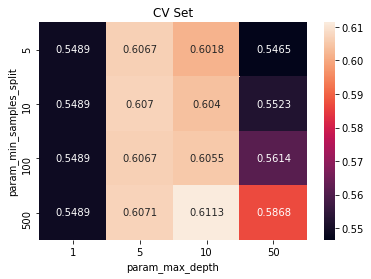

In [58]:

#https://stackoverflow.com/questions/56302647/how-to-plot-a-heatmap-and-find-best-hyperparameter-for-decision-tree-after-grids
results = pd.DataFrame.from_dict(model.cv_results_)
fig, ax = plt.subplots(1,1, figsize=(6,4))
max_scores = results.groupby(['param_min_samples_split', 'param_max_depth']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g');
ax.set_title('CV Set')


### observations
1.Heatmap shows correlations between values

2.From heatmap we observe that there is good correlation between sample split 500 and depth 10

## 3.4 Heatmap on CV and Train data

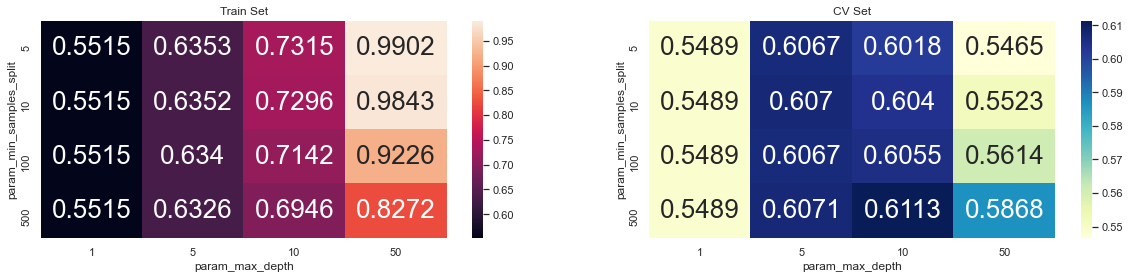

In [59]:
import seaborn as sns; sns.set()
max_scores1 = pd.DataFrame(model.cv_results_).groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,4))
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g', ax=ax[0],annot_kws={"size": 26})
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g', ax=ax[1],annot_kws={"size": 26},cmap="YlGnBu")
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

### observations
1.Heatmap shows correlations between values.Here we can observe heatmap of train and cv dataset

2.From heatmap we observe that there is good correlation between sample split 5,10 and depth 50 in train dataset and at depth 10 and samples 500 in cv dataset.

### 3.5 ROC curve with best lambda

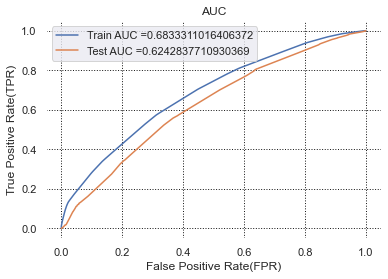

In [60]:
from sklearn.metrics import roc_curve, auc

dt_tfidf_testModel = DecisionTreeClassifier(class_weight='balanced',min_samples_split=bestMinSampleSplit_1,max_depth=bestMaxDepth_1)
dt_tfidf_testModel.fit(X_tr_tfidf, Y_train)



y_train_pred=dt_tfidf_testModel.predict_proba(X_tr_tfidf)[:,1]
predictions_train_tfidf=dt_tfidf_testModel.predict(X_tr_tfidf)

y_test_pred=dt_tfidf_testModel.predict_proba(X_te_tfidf)[:,1]
predictions_test_tfidf=dt_tfidf_testModel.predict(X_te_tfidf)

train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)

ax = plt.subplot()

auc_set1_train=auc(train_fpr, train_tpr)
auc_set1_test=auc(test_fpr, test_tpr)


ax.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
ax.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("AUC")
plt.grid(b=True, which='major', color='k', linestyle=':')
ax.set_facecolor("white")
plt.show()

### Observations
1.By looking ROC curve of Training FPR and TPR it looks sensible as it is greater than diagonal line 

2.By looking ROC curve of Test FPR and TPR is sensible .Model is generalize model

### 3.6 confusion matrix

In [61]:
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

y_train_predicted_withthroshold=predict(y_train_pred, tr_thresholds, train_fpr, train_tpr)
y_test_predicted_withthroshold=predict(y_test_pred, tr_thresholds, test_fpr, test_tpr)

cm_train=confusion_matrix(Y_train,y_train_predicted_withthroshold,labels=[0, 1])



print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(cm_train)
print("="*100)
print("Accuracy score  for Train")
print(accuracy_score(Y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr)))
print("="*100)

cm_test=confusion_matrix(Y_test,y_test_predicted_withthroshold,labels=[0, 1])

print("Test confusion matrix")
print(cm_test)
print("="*100)
print("Accuracy score  for Test")
accuracy_score_avgw2v=accuracy_score(Y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_tpr))
print(accuracy_score_avgw2v)
print("="*100)

Train confusion matrix
[[ 5037  2389]
 [17337 24278]]
Accuracy score  for Train
0.5977651352949572
Test confusion matrix
[[ 3454  2005]
 [13520 17073]]
Accuracy score  for Test
0.5693720181959392


confusion matrix for train data


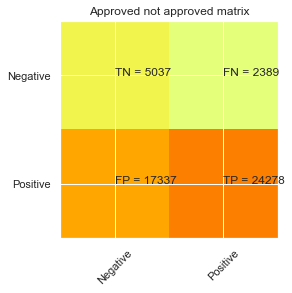

confusion matrix for Test data


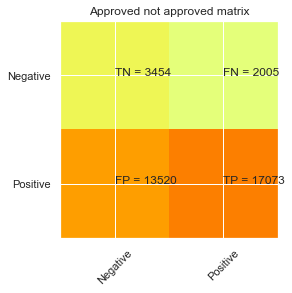

In [62]:
print("confusion matrix for train data")
print("="*100)
myplot_matrix1(cm_train)
print("confusion matrix for Test data")

print("="*100)
myplot_matrix1(cm_test)

### observations

1.TN and TP of train data and test data is higher.

2.Accuracy score on train data is 59 % and test data is 56 %.

3.TPR rate of test data is 89% .FPR rate of test data is 79%.TPR rate of test data is more than FPR rate of test data

4.TNR rate of testdata is 20% .FNR of test data is10%.TNR rate of test data is more than FNR rate of test data.

### 3.7 Worldcloud,Boxplot pdf on Tfidf

In [63]:
retrievingFalsePositives(1)

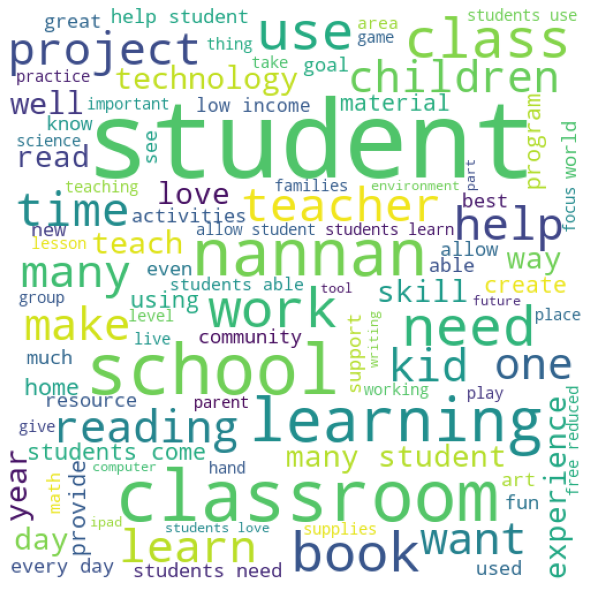

In [64]:
showtWordCloud(FP_essay_test_tfidf)

### observations
1.The bigger and bolder the word appears, the more often it’s mentioned within a given text and the more important it is.

2.Is shows important words like student,classroom,learning.

### 3.8 PDF on Teachers previously posted projects

No handles with labels found to put in legend.


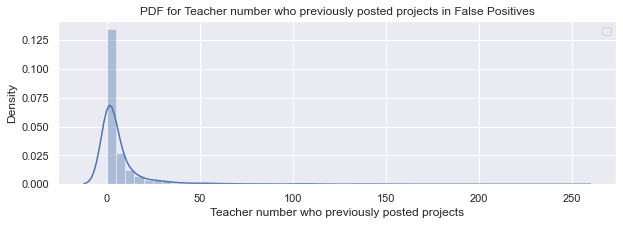

In [65]:
drawPDF(FP_previous_posted_test_tfidf)

### observations
1.Very less number of teachers posted projects from previous years

### 3.9 Boxplot on price

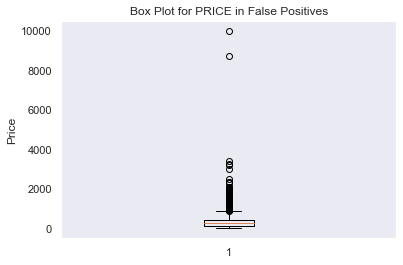

In [66]:
drawBoxPlot(FP_price_test_tfidf)

### observations

1.more price data shows less than 2000 .Very less has price more than 8000

## 4. SVM on TFIDF W2V

### 4.1 TFIDFW2V:Concatinating all the features

In [67]:
X_tr_tfidfw2v=hstack((Text_tfidf_w2v_train_essay,Text_tfidf_w2v_train_title,X_train_state_ohe,X_train_clean_categories_ohe,X_train_clean_subcategories_ohe,X_train_grade_ohe,X_train_teacher_ohe,X_train_quantity_norm,X_train_TPPP_norm,X_train_price_norm,X_train_essay_sentiment_neg,X_train_essay_sentiment_neu,X_train_essay_sentiment_pos,X_train_essay_sentiment_compound)).tocsr()
X_cr_tfidfw2v=hstack((Text_tfidf_w2v_cv_essay,Text_tfidf_w2v_cv_title,X_cv_state_ohe,X_cv_clean_categories_ohe,X_cv_clean_subcategories_ohe,X_cv_grade_ohe,X_cv_teacher_ohe,X_cv_quantity_norm,X_cv_TPPP_norm,X_cv_price_norm,X_cv_essay_sentiment_neg,X_cv_essay_sentiment_neu,X_cv_essay_sentiment_pos,X_cv_essay_sentiment_compound)).tocsr()
X_te_tfidfw2v=hstack((Text_tfidf_w2v_test_essay,Text_tfidf_w2v_test_title,X_test_state_ohe,X_test_clean_categories_ohe,X_test_clean_subcategories_ohe,X_test_grade_ohe,X_test_teacher_ohe,X_test_quantity_norm,X_test_TPPP_norm,X_test_price_norm,X_test_essay_sentiment_neg,X_test_essay_sentiment_neu,X_test_essay_sentiment_pos,X_test_essay_sentiment_compound)).tocsr()

print("Final Data matrix")
print(X_tr_tfidfw2v.shape, Y_train.shape)
print(X_cr_tfidfw2v.shape, Y_cv.shape)
print(X_te_tfidfw2v.shape, Y_test.shape)
print("="*100)

Final Data matrix
(49041, 707) (49041,)
(24155, 707) (24155,)
(36052, 707) (36052,)


### 4.2 Hyper parameter Tuning:simple for loop for Train and cross validation

In [68]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

Dt_tfidfw2v = DecisionTreeClassifier(class_weight='balanced')
parameters = {'max_depth':[1, 5, 10, 50],'min_samples_split':[5, 10, 100, 500]}
model = GridSearchCV(Dt_tfidfw2v, parameters, cv= 3, scoring='roc_auc',verbose=1,return_train_score=True,n_jobs=-1)

model.fit(X_tr_tfidfw2v,Y_train)
train_auc= model.cv_results_['mean_train_score']
train_auc_std= model.cv_results_['std_train_score']
cv_auc = model.cv_results_['mean_test_score']
cv_auc_std= model.cv_results_['std_test_score']
bestMaxDepth_1=model.best_params_['max_depth']
bestMinSampleSplit_1=model.best_params_['min_samples_split']
bestScore_1=model.best_score_
print("BEST MAX DEPTH: ",model.best_params_['max_depth']," BEST SCORE: ",model.best_score_,"BEST MIN SAMPLE SPLIT: ",model.best_params_['min_samples_split']) #clf.best_estimator_.alpha

Tfidfw2v_max_depth=model.best_params_['max_depth']
Tfidfw2v_best_score=model.best_score_
Tfidfw2v_best_min_split=model.best_params_['min_samples_split']

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  9.4min finished


BEST MAX DEPTH:  5  BEST SCORE:  0.6141339423340128 BEST MIN SAMPLE SPLIT:  500


## 4.3 Heatmap on Cross validation

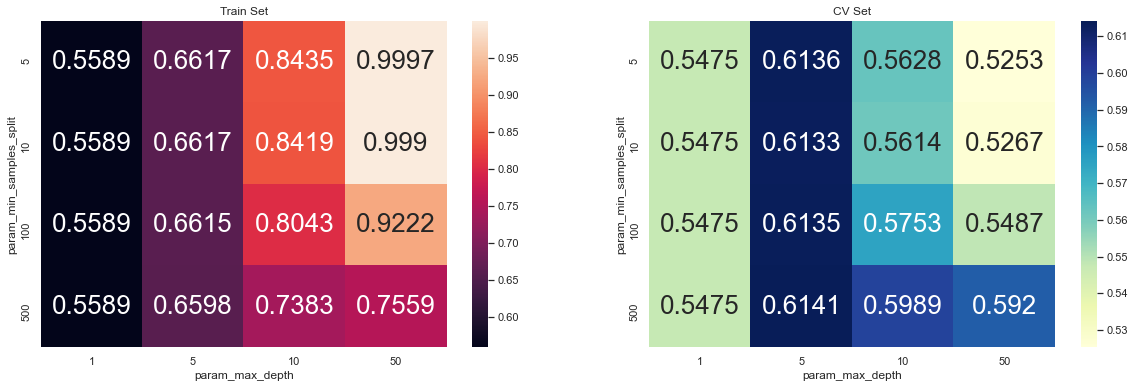

In [70]:
import seaborn as sns; sns.set()
max_scores2 = pd.DataFrame(model.cv_results_).groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores2.mean_train_score, annot = True, fmt='.4g', ax=ax[0],annot_kws={"size": 26})
sns.heatmap(max_scores2.mean_test_score, annot = True, fmt='.4g', ax=ax[1],annot_kws={"size": 26},cmap="YlGnBu")
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

#### observations
1.Good correlation for max depth 50 with sample split 5 and 10 in train set

2.Good correlation for max depth 10 with sample split  500 in CV set

### 4.4 ROC curve with best lambda

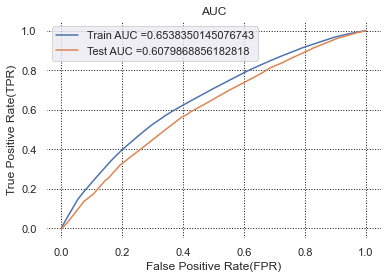

In [71]:
from sklearn.metrics import roc_curve, auc

dt_tfidfw2v_testModel = DecisionTreeClassifier(class_weight='balanced',min_samples_split=bestMinSampleSplit_1,max_depth=bestMaxDepth_1)
dt_tfidfw2v_testModel.fit(X_tr_tfidfw2v, Y_train)



y_train_pred=dt_tfidfw2v_testModel.predict_proba(X_tr_tfidfw2v)[:,1]
predictions_train_tfidfw2v=dt_tfidfw2v_testModel.predict(X_tr_tfidfw2v)

y_test_pred=dt_tfidfw2v_testModel.predict_proba(X_te_tfidfw2v)[:,1]
predictions_test_tfidfw2v=dt_tfidfw2v_testModel.predict(X_te_tfidfw2v)

train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)

ax = plt.subplot()

auc_set1_train=auc(train_fpr, train_tpr)
auc_set1_test=auc(test_fpr, test_tpr)


ax.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
ax.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("AUC")
plt.grid(b=True, which='major', color='k', linestyle=':')
ax.set_facecolor("white")
plt.show()


#### Observations
1.By looking ROC curve of Training FPR and TPR it looks sensible as it is greater than diagonal line 

2.By looking ROC curve of Test FPR and TPR is sensible .Model is generalize model

### 4.5 confusion matrix

In [72]:
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

y_train_predicted_withthroshold=predict(y_train_pred, tr_thresholds, train_fpr, train_tpr)
y_test_predicted_withthroshold=predict(y_test_pred, tr_thresholds, test_fpr, test_tpr)

cm_train=confusion_matrix(Y_train,y_train_predicted_withthroshold,labels=[0, 1])



print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(cm_train)
print("="*100)
print("Accuracy score  for Train")
print(accuracy_score(Y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr)))
print("="*100)

cm_test=confusion_matrix(Y_test,y_test_predicted_withthroshold,labels=[0, 1])

print("Test confusion matrix")
print(cm_test)
print("="*100)
print("Accuracy score  for Test")
accuracy_score_avgw2v=accuracy_score(Y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_tpr))
print(accuracy_score_avgw2v)
print("="*100)

Train confusion matrix
[[ 4689  2737]
 [16798 24817]]
Accuracy score  for Train
0.6016598356477233
Test confusion matrix
[[ 3303  2156]
 [13403 17190]]
Accuracy score  for Test
0.5684289359813602


confusion matrix for train data


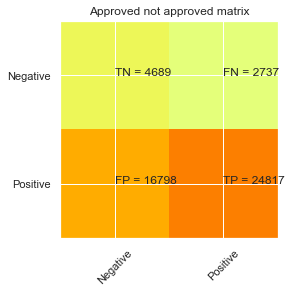

confusion matrix for Test data


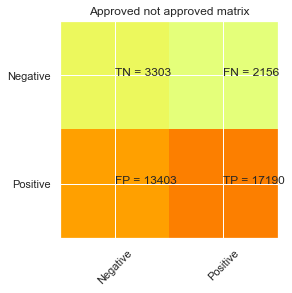

In [73]:
print("confusion matrix for train data")
print("="*100)
myplot_matrix1(cm_train)
print("confusion matrix for Test data")

print("="*100)
myplot_matrix1(cm_test)

#### observations
1.TN and TP of train data and test data is higher.

2.Accuracy score on train data is 60% and test data is 56%.

3.TPR rate of test data is 88% .FPR rate of test data is 80%.TPR rate of test data is more than FPR rate of test data

4.TNR rate of testdata is 19% .FNR of test data is 11%.TNR rate of test data is more than FNR rate of test data.


### 4.6 Wordcloud on tfidf

In [74]:
retrievingFalsePositives(2)

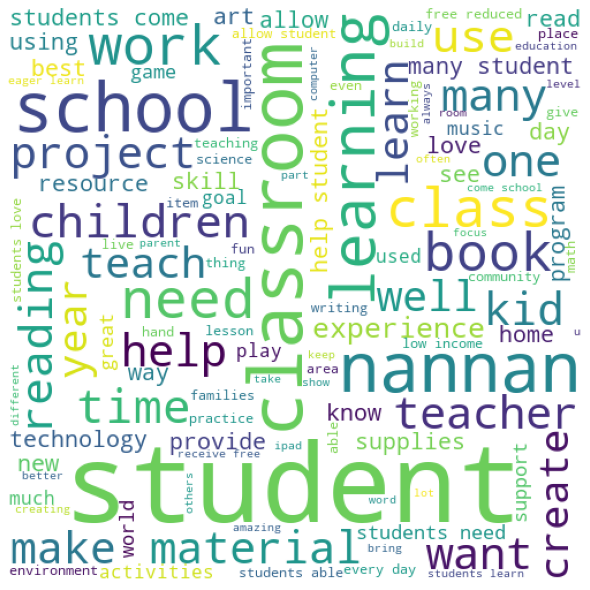

In [75]:
showtWordCloud(FP_essay_test_tfidfw2v)

#### observations 
1.Word cloud shows student,learning,classroom as important words

### 4.7 PDF on previously posted projects

No handles with labels found to put in legend.


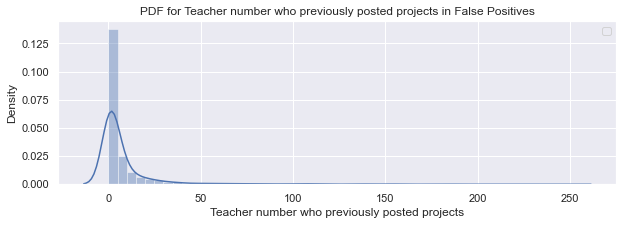

In [76]:
drawPDF(FP_previous_posted_test_tfidfw2v)

#### observations
1.Very less number of teachers posted projects from previous years

### 4.8 box plot on Price

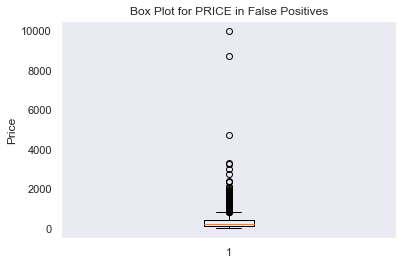

In [77]:
drawBoxPlot(FP_price_test_tfidfw2v)

#### observations
1.more price data shows less than 2000 .Very less has price more than 8000

## 5  Feature importance on data(analysis on selected important features)

### 5.1 selecting features

In [78]:
from sklearn.model_selection import GridSearchCV
def selectKImportance(model, X, k):
    return X[:,model.feature_importances_.argsort()[::-1][:k]]



In [79]:
from sklearn.metrics import roc_curve, auc

Dt_tfidf_imp_feature_Model = DecisionTreeClassifier(class_weight='balanced')
Dt_tfidf_imp_feature_Model.fit(X_tr_tfidf, Y_train)

DecisionTreeClassifier(class_weight='balanced')

In [80]:
nonZeroFeatures=0
for i in range (len(Dt_tfidf_imp_feature_Model.feature_importances_)):
    if(Dt_tfidf_imp_feature_Model.feature_importances_[i]>0):
        nonZeroFeatures=nonZeroFeatures+1

In [81]:
nonZeroFeatures

2415

In [82]:
x_train_impFeatureData_tfidf=selectKImportance(Dt_tfidf_imp_feature_Model,X_tr_tfidf,nonZeroFeatures)
x_test_impFeatureData_tfidf=selectKImportance(Dt_tfidf_imp_feature_Model,X_te_tfidf,nonZeroFeatures)

In [83]:
x_test_impFeatureData_tfidf.shape

(36052, 2415)

### 5.2 Decision tree on selected features

In [84]:

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

Dt_imp_feature_tfidf = DecisionTreeClassifier(class_weight='balanced')
parameters = {'max_depth':[1, 5, 10, 50],'min_samples_split':[5, 10, 100, 500]}
clf = GridSearchCV(Dt_imp_feature_tfidf, parameters, cv= 3, scoring='roc_auc',verbose=1,return_train_score=True,n_jobs=-1)

clf.fit(x_train_impFeatureData_tfidf,Y_train)     
        
train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score']
cv_auc_std= clf.cv_results_['std_test_score']
bestMaxDepth_3=clf.best_params_['max_depth']
bestMinSampleSplit_3=clf.best_params_['min_samples_split']
bestScore_3=clf.best_score_
print("BEST MAX DEPTH: ",clf.best_params_['max_depth']," BEST SCORE: ",clf.best_score_,"BEST MIN SAMPLE SPLIT: ",clf.best_params_['min_samples_split']) #clf.best_estimator_.alpha

Feimp_max_depth=clf.best_params_['max_depth']
Feimp_best_score=clf.best_score_
Feimp_min_split=clf.best_params_['min_samples_split']

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  1.6min finished


BEST MAX DEPTH:  10  BEST SCORE:  0.6106297596082132 BEST MIN SAMPLE SPLIT:  500


### 5.3 Heatmap on Train and crossvalidation

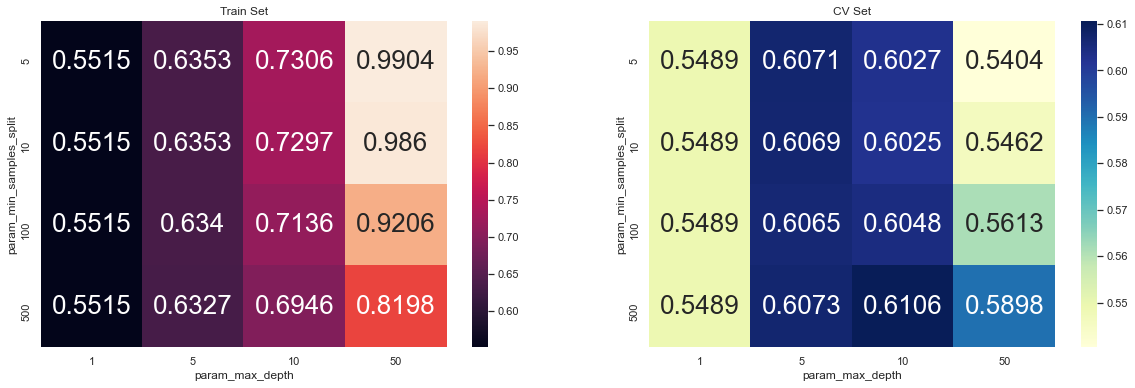

In [85]:
import seaborn as sns; sns.set()
max_scores3 = pd.DataFrame(clf.cv_results_).groupby(['param_min_samples_split', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(max_scores3.mean_train_score, annot = True, fmt='.4g', ax=ax[0],annot_kws={"size": 26})
sns.heatmap(max_scores3.mean_test_score, annot = True, fmt='.4g', ax=ax[1],annot_kws={"size": 26},cmap="YlGnBu")
ax[0].set_title('Train Set')
ax[1].set_title('CV Set')
plt.show()

#### observations
1. Good corelation between max depth 50 and sample split 5 and 10 in train set

2.Good corelation between max depth 10 and sample split 500

### 5.4 ROC curve on important features

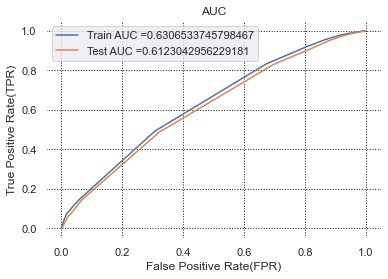

In [86]:
from sklearn.metrics import roc_curve, auc

Dt_tfidf_Feimp_Model = DecisionTreeClassifier(class_weight='balanced',min_samples_split=bestMinSampleSplit_1,max_depth=bestMaxDepth_1)
Dt_tfidf_Feimp_Model.fit(x_train_impFeatureData_tfidf, Y_train)



y_train_pred=Dt_tfidf_Feimp_Model.predict_proba(x_train_impFeatureData_tfidf)[:,1]
predictions_train_Feimp=Dt_tfidf_Feimp_Model.predict(x_train_impFeatureData_tfidf)

y_test_pred=Dt_tfidf_Feimp_Model.predict_proba(x_test_impFeatureData_tfidf)[:,1]
predictions_test_Feimp=Dt_tfidf_Feimp_Model.predict(x_test_impFeatureData_tfidf)

train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)

ax = plt.subplot()

auc_set1_train=auc(train_fpr, train_tpr)
auc_set1_test=auc(test_fpr, test_tpr)


ax.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
ax.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("AUC")
plt.grid(b=True, which='major', color='k', linestyle=':')
ax.set_facecolor("white")
plt.show()


#### Observations
1.By looking ROC curve of Training FPR and TPR it looks sensible as it is greater than diagonal line

2.By looking ROC curve of Test FPR and TPR is sensible .Model is generalize model



### 5.5 Confusion matrix

In [87]:
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

y_train_predicted_withthroshold=predict(y_train_pred, tr_thresholds, train_fpr, train_tpr)
y_test_predicted_withthroshold=predict(y_test_pred, tr_thresholds, test_fpr, test_tpr)

cm_train=confusion_matrix(Y_train,y_train_predicted_withthroshold,labels=[0, 1])



print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(cm_train)
print("="*100)
print("Accuracy score  for Train")
print(accuracy_score(Y_train, predict(y_train_pred, tr_thresholds, train_fpr, train_tpr)))
print("="*100)

cm_test=confusion_matrix(Y_test,y_test_predicted_withthroshold,labels=[0, 1])

print("Test confusion matrix")
print(cm_test)
print("="*100)
print("Accuracy score  for Test")
accuracy_score_avgw2v=accuracy_score(Y_test, predict(y_test_pred, tr_thresholds, test_fpr, test_tpr))
print(accuracy_score_avgw2v)
print("="*100)

Train confusion matrix
[[ 5097  2329]
 [20892 20723]]
Accuracy score  for Train
0.5264982361697356
Test confusion matrix
[[ 3618  1841]
 [15278 15315]]
Accuracy score  for Test
0.525158104959503


confusion matrix for train data


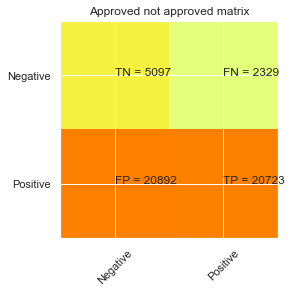

confusion matrix for Test data


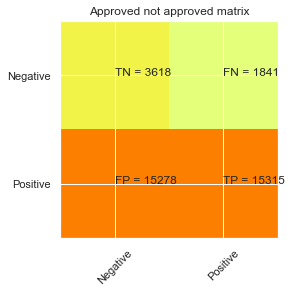

In [88]:
print("confusion matrix for train data")
print("="*100)
myplot_matrix1(cm_train)
print("confusion matrix for Test data")

print("="*100)
myplot_matrix1(cm_test)

## observations
1.TN and TP of train data and test data is higher.

2.Accuracy score on train data is 52% and test data is 52%.

3.TPR rate of test data is 89% .FPR rate of test data is 80%.TPR rate of test data is more than FPR rate of test data

4.TNR rate of testdata is 19% .FNR of test data is 10%.TNR rate of test data is more than FNR rate of test data.

### 5.6 Wordcloud on essay

In [89]:
retrievingFalsePositives(3)

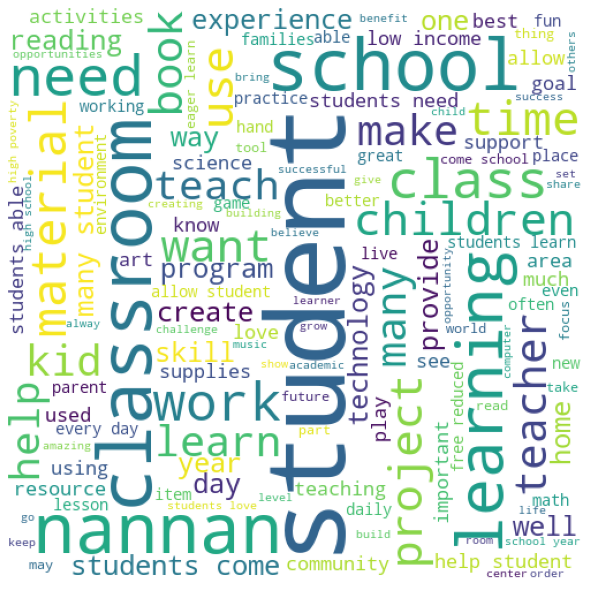

In [90]:
showtWordCloud(FP_essay_test_fetureimp)

### observations
1.Wordcloud shows classroom,learning,student as important words

### 5.7 PDF on previously posted projects of feature importance

No handles with labels found to put in legend.


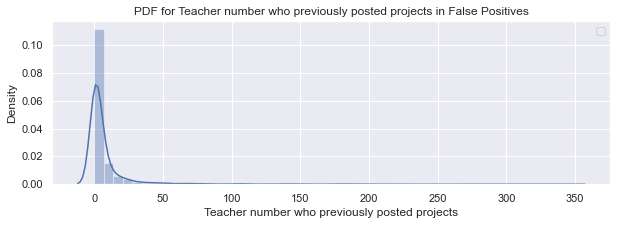

In [91]:
drawPDF(FP_previous_posted_test_fetureimp)

### observations
1.more price data shows less than 2000 .Very less has price more than 8000

### 5.8 Boxplot on price

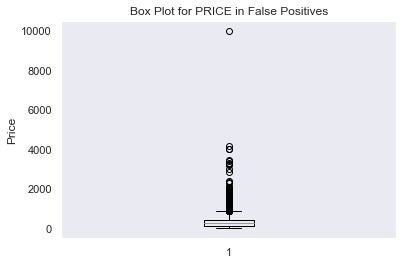

In [92]:
drawBoxPlot(FP_price_test_fetureimp)

### obsservations
1.1.more price data shows less than 2000 .Very less has price more than 8000

## 6. Model Performance Table

In [93]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Vectorizer", "max depth", "Best score","minimum split"]
x.add_row([" DT with TFIDF",Tfidf_max_depth,Tfidf_best_score,Tfidf_best_min_split])
x.add_row([" DT TFIDF W2V",Tfidfw2v_max_depth,Tfidfw2v_best_score,Tfidfw2v_best_min_split])
x.add_row(["DT with features importance",Feimp_max_depth,Feimp_best_score,Feimp_min_split])
print(x)

+-----------------------------+-----------+--------------------+---------------+
|          Vectorizer         | max depth |     Best score     | minimum split |
+-----------------------------+-----------+--------------------+---------------+
|         DT with TFIDF       |     10    | 0.6113047204226939 |      500      |
|         DT TFIDF W2V        |     5     | 0.6141339423340128 |      500      |
| DT with features importance |     10    | 0.6106297596082132 |      500      |
+-----------------------------+-----------+--------------------+---------------+


### observation
1.All model shows best score is 61% and minimum split 500